In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import argparse
from dataclasses import dataclass
from datetime import datetime as dt
import json
import os
from pathlib import Path
from pprint import pprint
import sys
if '..' not in sys.path:
    sys.path.append('..')
import shutil
import traceback
from typing import Union, Any, Optional
import yaml

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch

from sdp.ds.bop_data import read_models_info, read_scene_camera, read_scene_gt, \
    read_scene_gt_info
from sdp.ds.bop_dataset import BopDataset
from sdp.ds.bop_dataset import AUGNAME_DEFAULT
from sdp.models.segmenter.factory import create_segmenter
from segm.optim.factory import create_optimizer, create_scheduler

from b_01_train_aae import Config, TrainCfg, stack_imgs_maps

In [9]:
DATA_PATH = Path(os.path.expandvars('$HOME/data'))
BOP_PATH = DATA_PATH / 'bop'
ITODD_SUBDIR = 'itodd'
ITODD_BOP_PATH = BOP_PATH / ITODD_SUBDIR
print(f'BOP path: {BOP_PATH}')
TRAIN_ROOT_PATH = DATA_PATH / 'train_aae'

BOP path: /Users/misha/data/bop


In [13]:
cfg = Config(bop_root_path=BOP_PATH, train_root_path=TRAIN_ROOT_PATH, dataset_name=ITODD_SUBDIR,
             obj_id=1, img_size=256, train_subdir='last')
tcfg = TrainCfg.from_cfg(cfg)
tcfg


TrainCfg(bop_root_path=PosixPath('/Users/misha/data/bop'), train_root_path=PosixPath('/Users/misha/data/train_aae'), train_subdir='ds_itodd_obj_1_imsz_256_20231011_225846', dataset_name='itodd', obj_id=1, dt=datetime.datetime(2023, 10, 11, 22, 58, 46, 619260), img_size=256, last_epoch=0, epochs=100, batch_size=10, learning_rate=0.001, train_path=PosixPath('/Users/misha/data/train_aae/ds_itodd_obj_1_imsz_256_20231011_225846'), last_checkpoint_fpath=PosixPath('/Users/misha/data/train_aae/ds_itodd_obj_1_imsz_256_20231011_225846/last.pth'), best_checkpoint_fpath=PosixPath('/Users/misha/data/train_aae/ds_itodd_obj_1_imsz_256_20231011_225846/best.pth'))

In [14]:
device = torch.device(cfg.device)
skip_cache = False
ds = BopDataset.from_dir(tcfg.bop_root_path, tcfg.dataset_name, 'train_pbr', shuffle=True, skip_cache=skip_cache)
ds.shuffle()
objs_view = ds.get_objs_view(tcfg.obj_id, tcfg.batch_size, tcfg.img_size, return_tensors=True,
                                keep_source_images=False, keep_cropped_images=False)
ov_train, ov_val = objs_view.split((-1, 0.1))
ov_train.set_aug_name(AUGNAME_DEFAULT)
it_buffer_sz = 10

inp_ch, n_cls = 9, 6
backbone = 'vit_tiny_patch16_384'
model_cfg = {
    'n_cls': n_cls,
    'backbone': backbone,
    'image_size': (tcfg.img_size, tcfg.img_size),
    'channels': inp_ch,
    'patch_size': 16,
    'd_model': 192,
    'n_heads': 3,
    'n_layers': 12,
    'normalization': 'vit',
    'distilled': False,
    'decoder': {
        'name': 'mask_transformer',
        'drop_path_rate': 0.1,
        'dropout': 0.1,
        'n_layers': 2
    }
}
opt_cfg = {
    'opt': 'sgd',
    'lr': 0.001,
    'weight_decay': 0.0,
    'momentum': 0.9,
    'clip_grad': None,
    'sched': 'polynomial',
    'epochs': tcfg.epochs,
    'min_lr': 1e-5,
    'poly_power': 0.9,
    'poly_step_size': 1,
    'iter_max': tcfg.epochs * len(ov_train),
    'iter_warmup': 0.0,
}
model = create_segmenter(model_cfg)
model.to(device)
print(model)


Reading dataset from /Users/misha/data/bop/itodd/.sdp/v0.0.1
min_mask_ratio: 20671 --> 18066
min_bbox_dim_ratio: 18066 --> 16071
default_cfg: {'url': 'https://storage.googleapis.com/vit_models/augreg/Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384.npz', 'file': None, 'state_dict': None, 'hf_hub_id': None, 'hf_hub_filename': None, 'source': None, 'architecture': None, 'tag': None, 'custom_load': True, 'input_size': (3, 384, 384), 'test_input_size': None, 'min_input_size': None, 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 1.0, 'test_crop_pct': None, 'crop_mode': 'center', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'num_classes': 1000, 'label_offset': None, 'label_names': None, 'label_descriptions': None, 'pool_size': None, 'test_pool_size': None, 'first_conv': 'patch_embed.proj', 'classifier': 'head', 'license': None, 'description': None, 'origin_url': None, 'paper_name': None, 'paper_ids': None, 'notes': None}


In [15]:

opt_args = argparse.Namespace()
opt_vars = vars(opt_args)
for k, v in opt_cfg.items():
    opt_vars[k] = v

optimizer = create_optimizer(opt_args, model)
lr_scheduler = create_scheduler(opt_args, optimizer)
criterion = torch.nn.CrossEntropyLoss()

if cfg.train_subdir == 'last' and tcfg.last_checkpoint_fpath.exists():
    checkpoint = torch.load(tcfg.last_checkpoint_fpath)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    tcfg.last_epoch = checkpoint['last_epoch']

model.train()


Segmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(9, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (mlp): FeedForward(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
      )
    )
    (norm):

In [16]:
i_batch = 0
gt_item = ov_train.get_gt_batch(i_batch)
x = stack_imgs_maps(gt_item.maps_crop_tn, gt_item.maps_names, gt_item.imgs_crop_tn)
y_gt = stack_imgs_maps(gt_item.maps_crop_tn, gt_item.maps_names)
x, y_gt = x.to(device), y_gt.to(device)
y_pred = model.forward(x)
print(y_pred.shape, y_gt.shape)

torch.Size([10, 6, 256, 256]) torch.Size([10, 6, 256, 256])


In [17]:
y_pred.dtype, y_gt.dtype
y_pred.min(), y_pred.max(), y_gt.min(), y_gt.max()

(tensor(-2.1528, grad_fn=<MinBackward1>),
 tensor(2.1815, grad_fn=<MaxBackward1>),
 tensor(0.),
 tensor(1.))

In [18]:
loss: torch.Tensor = criterion(y_pred, y_gt)
loss

tensor(3.9607, grad_fn=<DivBackward1>)

In [19]:
imgs_gt = x
imgs_pred = y_pred
n_maps = 2
max_imgs = 5

In [42]:
imgs_gt.shape
img_sz = imgs_gt.shape[-1]
assert imgs_gt.shape[-2] == img_sz
assert imgs_gt.shape[-3] // 3 == n_maps + 1
assert imgs_pred.shape[-2] == imgs_pred.shape[-1] == img_sz
assert imgs_pred.shape[-3] // 3 == n_maps

nr, nc = min(imgs_gt.shape[0], max_imgs), 2 * n_maps + 1
height, width = nr * img_sz, nc * img_sz

slim = lambda i: slice(i * img_sz, (i + 1) * img_sz)
slch = lambda i: slice(i * 3, (i + 1) * 3)
res = torch.zeros(3, height, width, dtype=torch.float32)
for i in range(nr):
    v_slice = slim(i)
    # print(res[:, v_slice, slim(0)].shape, imgs_gt[i, slch(0)].shape)
    res[:, v_slice, slim(0)] = imgs_gt[i, slch(0)]
    for i_map in range(n_maps):
        # First image is skipped
        res[:, v_slice, slim(1 + i_map)] = imgs_gt[i, slch(1 + i_map)]
        res[:, v_slice, slim(1 + n_maps + i_map)] = imgs_pred[i, slch(i_map)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


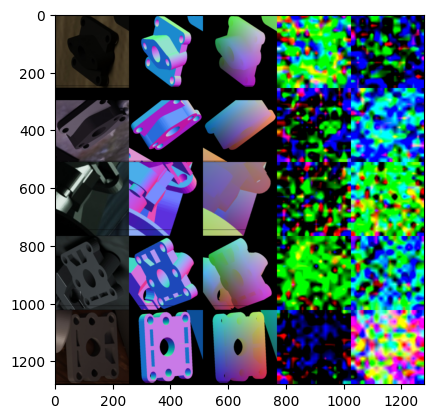

In [53]:
# res_img = torch.permute(res, (2, 0, 1)).numpy(force=True)
res_img = torch.permute(res, (1, 2, 0))
res_img = res_img.detach().cpu().resolve_conj().resolve_neg().numpy()
plt.imshow(res_img)